# Excercise 1

In the tutorial you saw how to compute LDA for a two class problem. In this excercise we will work on a multi-class problem. We will be working with the famous Iris dataset that has been deposited on the UCI machine learning repository
(https://archive.ics.uci.edu/ml/datasets/Iris).

The iris dataset contains measurements for 150 iris flowers from three different species.

The three classes in the Iris dataset:
1. Iris-setosa (n=50)
2. Iris-versicolor (n=50)
3. Iris-virginica (n=50)

The four features of the Iris dataset:
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm

<img src="iris_petal_sepal.png">



In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import pi
from sklearn import mixture
from sklearn.linear_model import SGDClassifier
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler

### Importing the dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']
dataset = pd.read_csv(url, names=names)

dataset.tail()

,sepal-length,sepal-width,petal-length,petal-width,Class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


### Data preprocessing

Once dataset is loaded into a pandas data frame object, the first step is to divide dataset into features and corresponding labels and then divide the resultant dataset into training and test sets. The following code divides data into labels and feature set:

In [3]:
X = dataset.iloc[:, 0:4].values
y = dataset.iloc[:, 4].values
print(X.shape,y.shape)

(150, 4) (150,)


The above script assigns the first four columns of the dataset i.e. the feature set to X variable while the values in the fifth column (labels) are assigned to the y variable.

The following code divides data into training and test sets:

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print(X_train.shape,X_test.shape)

(120, 4) (30, 4)


#### Feature Scaling

We will now perform feature scaling as part of data preprocessing too. For this task, we will be using scikit learn `StandardScalar`.

In [5]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## Write your code below

Write you code below to LDA on the IRIS dataset and compute the overall accuracy of the classifier.

In [6]:
# Calculating covariance of an input matrix
def calc_cov_matrix(X_input):
  n_samples = np.shape(X_input)[0]
  print(n_samples)
  cov_matrix = np.array((1 / (n_samples-1)) * (X_input - X_input.mean(axis=0)).T.dot(X_input - X_input.mean(axis=0)))

  return cov_matrix

In [7]:
def LDA(X_train, y_train):
    
    classes,idx,count=np.unique(y_train,return_inverse=True,return_counts=True)
    num_classes=range(classes.shape[0])
    zip_iterator = zip(num_classes, classes)
    classes_Dict = dict(zip_iterator)
    sorted_X=np.empty(X_train.shape)
    sorted_y=np.empty(y_train.shape)
    #print(idx)
    
    #print(X_train)
    # Sorting samples based on the classes to extract them separately
    j=0
    for i in num_classes:
        for k in range(X_train.shape[0]):
            if idx[k]==i:
                #print(i,k,X_train[k])
                sorted_X[j]=X_train[k]
                #print(i,j,sorted_X[j])
                sorted_y[j]=i
                j+=1

    means=np.empty((len(num_classes),X_train.shape[1]))
    
    j=0
    for i in num_classes:
        #print(sorted_X[j:j+count[i]])
        means[i]=np.mean(sorted_X[j:j+count[i]], axis=0)
        #print(means[i])
        j=j+count[i]
    print(means)
    #print(sorted_X)
    Mean=np.mean(means)
    SB=np.zeros((sorted_X.shape[1],sorted_X.shape[1]))
    SW=np.zeros((sorted_X.shape[1],sorted_X.shape[1]))
    j=0
    for i in num_classes:
        SB += np.dot((means[i]-Mean),(means[i]-Mean).T)
        SW += calc_cov_matrix(sorted_X[j:j+count[i]])
        j=j+count[i]
    #print(SB)
    #print(SW)
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(SW).dot(SB))
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eigvals[i]), eigvecs[:,i]) for i in range(len(eigvals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

    # Visually confirm that the list is correctly sorted by decreasing eigenvalues
    #print(eig_pairs)
    print('Eigenvalues in decreasing order:\n')
    for i in eig_pairs:
        print(i[0])
    num_features=X_train.shape[1]
    W = np.hstack((eig_pairs[0][1].reshape(num_features,1), eig_pairs[1][1].reshape(num_features,1)))
    #W=eig_pairs[0][1].reshape(num_features,1)
    print('Matrix W:\n', W.real)
    return W.real,means,classes_Dict

In [8]:
#Calling LDA function to get the new representation,original class means from train_data,mapping of classes names to class id 0,1,2
trained_weights,Class_means,Class_Dict = LDA(X_train, y_train)
print(Class_Dict)
X_train_new = np.dot(X_train, trained_weights)
#Fitting Gaussian Mixture model on the new train data representation
#Comparing new class means and the Gaussian Cluster means to know the map between class and clusters
new_class_mean=np.dot(Class_means,trained_weights)
model = mixture.GaussianMixture(n_components=Class_means.shape[0], max_iter=5000, covariance_type='full').fit(X_train_new)
cluster_means=model.means_
# print(cluster_means)
# print(new_class_mean)
pairs=[] #mapping classes to cluster in Class_Cluster dictionary
for i in range(Class_means.shape[0]):
    d0=distance.euclidean(cluster_means[i], new_class_mean[0])
    d1=distance.euclidean(cluster_means[i], new_class_mean[1])
    d2=distance.euclidean(cluster_means[i], new_class_mean[2])
    if d0<d1 and d0<d2:
        pairs.append((i,Class_Dict[0]))
    elif d1<d0 and d1<d2:
        pairs.append((i,Class_Dict[1]))
    elif d2<d0 and d2<d1:
        pairs.append((i,Class_Dict[2]))

Class_Cluster=dict(pairs)
#print(Class_Cluster)

[[-1.01430344  0.84162281 -1.30206141 -1.25476575]
 [ 0.10997694 -0.65587668  0.25058115  0.1416812 ]
 [ 0.84890676 -0.21854593  0.99560358  1.04531222]]
40
37
43
Eigenvalues in decreasing order:

69.073917495997
3.7294340972100905e-15
3.7294340972100905e-15
0.0
Matrix W:
 [[ 0.22608425 -0.64174385]
 [-0.01200538  0.0063966 ]
 [-0.92818604 -0.08161754]
 [-0.29531755  0.71696479]]
{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}


In [9]:
#Predicting the class of test samples
y_test_predicted=[]
y_test_cluster=[]
list0=[]
list1=[]
list2=[]
X_test_new = np.dot(X_test, trained_weights)
for i  in range(X_test_new.shape[0]):
    d0=distance.euclidean(cluster_means[0], X_test_new[i])
    d1=distance.euclidean(cluster_means[1], X_test_new[i])
    d2=distance.euclidean(cluster_means[2], X_test_new[i])
    if d0<d1 and d0<d2:
        y_test_predicted.append(Class_Cluster[0])
        y_test_cluster.append(0)
        list0.append(X_test_new[i])
    elif d1<d0 and d1<d2:
        y_test_predicted.append(Class_Cluster[1])
        y_test_cluster.append(1)
        list1.append(X_test_new[i])
    elif d2<d0 and d2<d1:
        y_test_predicted.append(Class_Cluster[2])
        y_test_cluster.append(2)
        list2.append(X_test_new[i])
y_test_predicted=np.array(y_test_predicted)



In [10]:
print(new_class_mean,cluster_means)

[[ 1.33968755 -0.13704528]
 [-0.24168877  0.0063562 ]
 [-1.03825622  0.12201469]] [[ 1.33968755 -0.13704528]
 [-1.00772848  0.13920636]
 [-0.19864819 -0.03004901]]


In [11]:
# Accuracy Calculation
miscls_test_points=[]
for i in range(y_test_predicted.shape[0]):
    #print(y_test_predicted[i],y_test[i])
    if y_test_predicted[i] != y_test[i]:
        miscls_test_points.append(X_test_new[i])

accuracy = 1-(len(miscls_test_points)/y_test_predicted.shape[0])
print("Accuracy: ", accuracy*100)
#print(miscls_test_points)



Accuracy:  96.66666666666667


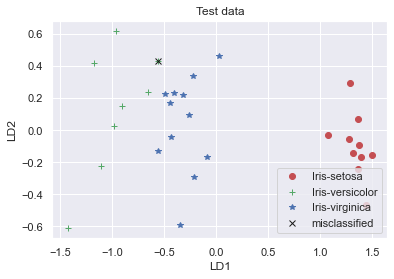

In [12]:
#Plotting the classes for test data
class0=np.array(list0)
class1=np.array(list1)
class2=np.array(list2)
class_mis=np.array(miscls_test_points)
#print(class_mis)
fig, ax = plt.subplots()
class_0,=plt.plot(class0[:,0],class0[:,1],'ro', label='Iris-setosa')
class_1,=plt.plot(class1[:,0],class1[:,1],'g+', label='Iris-versicolor')
class_2,=plt.plot(class2[:,0],class2[:,1],'b*',label='Iris-virginica')
mis,=plt.plot(class_mis[:,0],class_mis[:,1],'kx', label='misclassified')
#plt.set_label('Test Data of different classes')
ax.set_xlabel('LD1')
ax.set_ylabel('LD2')
plt.title('Test data')
#plt.legend() 
plt.legend(handles=[class_0, class_1, class_2,mis])
plt.legend(loc='lower right', fancybox=True)
plt.tight_layout
plt.show()


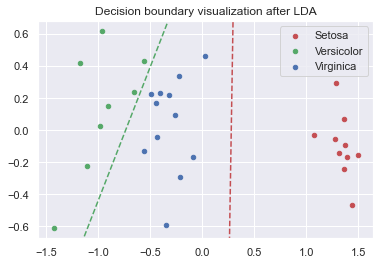

In [18]:
#Visualization of decision boundary in above plot
def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

    plt.plot([xmin, xmax], [line(xmin), line(xmax)],
             ls="--", color=color)
colors = "rgb"
label_dict = {0: 'Setosa', 1: 'Versicolor', 2:'Virginica'}
X=X_test_new
y=y_test_cluster
clf = SGDClassifier(alpha=0.001, max_iter=100).fit(X, y) 
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color,label=label_dict[i],
                cmap=plt.cm.Paired, s=20)
plt.title("Decision boundary visualization after LDA")
plt.axis('tight')


xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_


for i, color in zip(clf.classes_, colors):
    plot_hyperplane(i, color)
    if i==1:
        break
plt.legend()
plt.show()